# Mod 3 Final Project: Chicago Car Crashes

* Student name: John Cho
* Student pace: full time online
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL:

In [276]:
# Importing libraries, data
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm
import seaborn as sns
import statsmodels.api as sm
import itertools
import pickle

#import our cleaned dataset using pickle
with open('data.pickle', 'rb') as f:
    df = pickle.load(f)
df.shape

(294798, 28)

## Addressing Class Imbalance
### An important aspect of this dataset and our target prediction is that they represent a ***class imbalance problem.*** This is where our predicted event occurs so infrequently (per below, less than 2% of the time) that a model simply predicting 'non-severe' every time would be over 98% accurate!
> Most machine learning techniques revolve around accuracy to determine how 'good' a predictive model is. If we are hypothetically advising the City of Chicago on how to spend money/efforts to reduce severe crashes, our model needs to very good at correctly predicting ***nearly EVERY SEVERE crash*** by eliminating 'false negatives' and be okay with 'false positives' (more on that later).

> This is similar to our current coronavirus climate where the testing kits absolutely CANNOT report *negative for positive candidates* (false negative). The additional costs to government/business/community efforts would be several magnitudes greater than if the kits erred on the 'safe' side of incorrectly reporting *negative candidates as positive* (the 'false positives' would be soon discovered thereafter and sent home). This metric is measured by ***recall*** which captures exactly this predictive error that we want to minimize.

In [277]:
df.SEVERE.value_counts(normalize=True)

0    0.981642
1    0.018358
Name: SEVERE, dtype: float64

In [278]:
# Assigning target and feature variables (as float per model performance recommendations)
y = df.SEVERE.astype('float64')
features = df.drop('SEVERE',axis=1).columns

# Dummy encoding
dummies = pd.get_dummies(df[features], drop_first=True, dtype=float)

# Normalize by performing min-max scaling from 0 to 1
for col in dummies.columns:
    dummies[col] = (dummies[col] - min(dummies[col]))/ (max(dummies[col]) - min(dummies[col]))

y.shape, dummies.shape

((294798,), (294798, 48))

## Build logistic regression model using statsmodels

In [279]:
# Create function
def stats_model():
    X = sm.tools.add_constant(dummies)
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()
    display(result.summary())

stats_model()

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.059690
         Iterations 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 SEVERE   No. Observations:               294798
Model:                          Logit   Df Residuals:                   294749
Method:                           MLE   Df Model:                           48
Date:                Sun, 05 Apr 2020   Pseudo R-squ.:                  0.3482
Time:                        15:32:05   Log-Likelihood:                -17597.
converged:                       True   LL-Null:                       -26997.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -6.4221      0.459    -13.995      0.000      -7.322      -5.523
LANE_CNT                                      0.1353      0.053      2.538      0.011       0.031       0.240
REPORT_TYPE                                   0.4235      0.050      8.404      0.000       0.325       0.522
HIT_AND_RUN_I                                -0.1557      0.042     -3.714      0.000      -0.238      -0.074
NUM_UNITS                                    -0.0705      0.070     -1.003      0.316      -0.208       0.067
INJURIES_TOTAL                                4.7904      0.065     73.954      0.000       4.663       4.917
NO_TCD                                        0.0488      0.033      1.477      0.140      -0.016       0.114
NON_DRIVERS                                  -0.5546      0.041    -13.370      0.000      -0.636      -0.473
OOSTATE                                      -0.0251      0.047     -0.537      0.591      -0.116       0.066
WEIGHT_DIFF                                   0.0376      0.032      1.175      0.240      -0.025       0.100
SPEEDING                                      0.4438      0.115      3.859      0.000       0.218       0.669
UNDER25                                      -0.0762      0.039     -1.936      0.053      -0.153       0.001
ALCOHOL                                       0.5066      0.066      7.683      0.000       0.377       0.636
AIRBAG                                        0.3934      0.043      9.129      0.000       0.309       0.478
EJECTION                                      1.1502      0.060     19.068      0.000       1.032       1.268
POSTED_SPEED_LIMIT_low                        0.0191      0.418      0.046      0.964      -0.800       0.838
POSTED_SPEED_LIMIT_med                        0.2891      0.410      0.705      0.481      -0.515       1.093
WEATHER_CONDITION_CLOUDY/RAIN                -0.0975      0.063     -1.559      0.119      -0.220       0.025
WEATHER_CONDITION_FOG/SMOKE/HAZE             -0.5774      0.332     -1.741      0.082      -1.227       0.072
WEATHER_CONDITION_SEVERE_WINDS              -60.2672   1.09e+13  -5.51e-12      1.000   -2.14e+13    2.14e+13
WEATHER_CONDITION_SNOW/ICY                   -0.0774      0.104     -0.747      0.455      -0.280       0.126
WEATHER_CONDITION_UNKNOWN/OTHER              -0.1425      0.133     -1.075      0.283      -0.402       0.117
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD     0.0391      0.073      0.534      0.594      -0.104       0.183
LIGHTING_CONDITION_DAWN                       0.1421      0.124      1.144      0.253      -0.101       0.386
LIGHTING_CONDITION_DAYLIGHT                  -0.0099      0.085     -0.118      0.906      -0.176       0.156
LIGHTING_CONDITION_DUSK                       0.0176      0.110      0.161      0.872      -0.197       0.233
FIRST_CRASH_TYPE_PARKED/FIXED                 0.231

#### Let's do an initial sweep of dropping columns with the worst P-values (>0.3)

In [280]:
dummies = dummies.drop(columns=['NUM_UNITS','OOSTATE','POSTED_SPEED_LIMIT_low','POSTED_SPEED_LIMIT_med',
                          'WEATHER_CONDITION_SEVERE_WINDS','WEATHER_CONDITION_SNOW/ICY',
                          'LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD','LIGHTING_CONDITION_DAYLIGHT','LIGHTING_CONDITION_DUSK',
                          'ALIGNMENT_HILLCREST','ROAD_DEFECT_UNKNOWN/OTHER/DEBRIS','CRASH_HOUR_NIGHT','CRASH_DAY_OF_WEEK_WORK',
                          'CRASH_MONTH_HOT','CRASH_MONTH_MILD','POL_NOTIFY_TIME_MID'])
# Rerun model again
stats_model()

Optimization terminated successfully.
         Current function value: 0.059724
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 SEVERE   No. Observations:               294798
Model:                          Logit   Df Residuals:                   294765
Method:                           MLE   Df Model:                           32
Date:                Sun, 05 Apr 2020   Pseudo R-squ.:                  0.3478
Time:                        15:32:10   Log-Likelihood:                -17606.
converged:                       True   LL-Null:                       -26997.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -6.1755      0.167    -36.974      0.000      -6.503      -5.848
LANE_CNT                               0.1504      0.053      2.835      0.005       0.046       0.254
REPORT_TYPE                            0.4297      0.050      8.590      0.000       0.332       0.528
HIT_AND_RUN_I                         -0.1630      0.041     -3.939      0.000      -0.244      -0.082
INJURIES_TOTAL                         4.7835      0.064     74.962      0.000       4.658       4.909
NO_TCD                                 0.0369      0.033      1.122      0.262      -0.028       0.101
NON_DRIVERS                           -0.5526      0.041    -13.377      0.000      -0.634      -0.472
WEIGHT_DIFF                            0.0304      0.032      0.960      0.337      -0.032       0.093
SPEEDING                               0.4360      0.115      3.800      0.000       0.211       0.661
UNDER25                               -0.0778      0.039     -1.980      0.048      -0.155      -0.001
ALCOHOL                                0.5051      0.066      7.683      0.000       0.376       0.634
AIRBAG                                 0.4017      0.043      9.342      0.000       0.317       0.486
EJECTION                               1.1529      0.060     19.185      0.000       1.035       1.271
WEATHER_CONDITION_CLOUDY/RAIN         -0.0853      0.059     -1.443      0.149      -0.201       0.031
WEATHER_CONDITION_FOG/SMOKE/HAZE      -0.5613      0.331     -1.696      0.090      -1.210       0.087
WEATHER_CONDITION_UNKNOWN/OTHER       -0.1372      0.131     -1.044      0.296      -0.395       0.120
LIGHTING_CONDITION_DAWN                0.1480      0.099      1.501      0.133      -0.045       0.341
FIRST_CRASH_TYPE_PARKED/FIXED          0.2293      0.115      2.001      0.045       0.005       0.454
FIRST_CRASH_TYPE_PED/CYCLE/OTHER       1.8864      0.115     16.410      0.000       1.661       2.112
FIRST_CRASH_TYPE_REAR/NONCOL          -0.1578      0.115     -1.377      0.169      -0.383       0.067
FIRST_CRASH_TYPE_SIDESWIPE            -0.3551      0.125     -2.831      0.005      -0.601      -0.109
FIRST_CRASH_TYPE_TURN/ANGLE           -0.2216      0.111     -2.000      0.045      -0.439      -0.004
ALIGNMENT_STRAIGHT                    -0.3346      0.104     -3.203      0.001      -0.539      -0.130
ROADWAY_SURFACE_COND_SNOW/ICE/SAND    -0.3082      0.083     -3.701      0.000      -0.471      -0.145
ROADWAY_SURFACE_COND_UNKNOWN/OTHER     0.0984      0.100      0.987      0.324      -0.097       0.294
ROADWAY_SURFACE_COND_WET               0.0861      0.055      1.566      0.117      -0.022       0.194
ROAD_DEFECT_WORN/SHOULDER/RUT         -0.1753      0.125     -1.398      0.162      -0.421       0.071
DAMAGE_OVER $1,500                     0.5463      0.040     13.806      0.000       0.469       0.624
STREET_DIRECTION_S/W                   0.0568   

#### We'll drop the 4 columns with P-value>0.2 and note which ones are borderline (>0.05)

In [281]:
dummies = dummies.drop(columns=['NO_TCD','WEIGHT_DIFF','WEATHER_CONDITION_UNKNOWN/OTHER','ROADWAY_SURFACE_COND_UNKNOWN/OTHER'])

# Rerun model again
stats_model()

Optimization terminated successfully.
         Current function value: 0.059730
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 SEVERE   No. Observations:               294798
Model:                          Logit   Df Residuals:                   294769
Method:                           MLE   Df Model:                           28
Date:                Sun, 05 Apr 2020   Pseudo R-squ.:                  0.3478
Time:                        15:32:14   Log-Likelihood:                -17608.
converged:                       True   LL-Null:                       -26997.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -6.1276      0.163    -37.505      0.000      -6.448      -5.807
LANE_CNT                               0.1473      0.053      2.781      0.005       0.043       0.251
REPORT_TYPE                            0.4298      0.050      8.601      0.000       0.332       0.528
HIT_AND_RUN_I                         -0.1575      0.041     -3.852      0.000      -0.238      -0.077
INJURIES_TOTAL                         4.7805      0.064     75.064      0.000       4.656       4.905
NON_DRIVERS                           -0.5516      0.041    -13.359      0.000      -0.633      -0.471
SPEEDING                               0.4366      0.115      3.805      0.000       0.212       0.661
UNDER25                               -0.0804      0.039     -2.050      0.040      -0.157      -0.004
ALCOHOL                                0.5054      0.066      7.690      0.000       0.377       0.634
AIRBAG                                 0.3964      0.043      9.258      0.000       0.312       0.480
EJECTION                               1.1554      0.060     19.242      0.000       1.038       1.273
WEATHER_CONDITION_CLOUDY/RAIN         -0.0788      0.059     -1.342      0.180      -0.194       0.036
WEATHER_CONDITION_FOG/SMOKE/HAZE      -0.5551      0.331     -1.677      0.094      -1.204       0.094
LIGHTING_CONDITION_DAWN                0.1472      0.099      1.494      0.135      -0.046       0.340
FIRST_CRASH_TYPE_PARKED/FIXED          0.2313      0.114      2.021      0.043       0.007       0.456
FIRST_CRASH_TYPE_PED/CYCLE/OTHER       1.8700      0.114     16.348      0.000       1.646       2.094
FIRST_CRASH_TYPE_REAR/NONCOL          -0.1658      0.114     -1.449      0.147      -0.390       0.058
FIRST_CRASH_TYPE_SIDESWIPE            -0.3566      0.125     -2.845      0.004      -0.602      -0.111
FIRST_CRASH_TYPE_TURN/ANGLE           -0.2378      0.110     -2.161      0.031      -0.453      -0.022
ALIGNMENT_STRAIGHT                    -0.3369      0.104     -3.228      0.001      -0.541      -0.132
ROADWAY_SURFACE_COND_SNOW/ICE/SAND    -0.3136      0.083     -3.775      0.000      -0.476      -0.151
ROADWAY_SURFACE_COND_WET               0.0767      0.054      1.407      0.159      -0.030       0.183
ROAD_DEFECT_WORN/SHOULDER/RUT         -0.1703      0.125     -1.358      0.174      -0.416       0.075
DAMAGE_OVER $1,500                     0.5470      0.040     13.826      0.000       0.469       0.625
STREET_DIRECTION_S/W                   0.0569      0.033      1.707      0.088      -0.008       0.122
CRASH_HOUR_DAY                        -0.0826      0.035     -2.339      0.019      -0.152      -0.013
CRASH_HOUR_DUSK                       -0.1629      0.045     -3.583      0.000      -0.252      -0.074
POL_NOTIFY_TIME_LOW                    0.4897      0.065      7.523      0.000       0.362       0.617
POL_NOTIFY_TIME_QUICK                  0.8905   

#### As we can see, the Pseudo R-squared (a measurement of 'good fit' using Maximum Likelihood Estimation) remained virtually unchanged at 35% but our number of column features has been reduced by 20 (out of 48).
- Now let's fit a logistic regression model using scikit-learn.

In [282]:
# First perform train-test split at default 25% test split size
X = sm.tools.add_constant(dummies)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)  #specify random seed for reproducibility

# fit_intercept=False because we already added a constant
logreg = LogisticRegression(fit_intercept = False, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
print(model_log, model_log.coef_,'\n')

# Make model predictions
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

# Training set accuracy - correct predictions will have a difference of 0 and incorrect 1 or -1
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())  #exact count
print(pd.Series(residuals).value_counts(normalize=True),'\n')  #ratio of correct (0) to incorrect (1)
residuals = np.abs(y_test - y_hat_test)  #test set
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) [[-5.90349728  0.18980537  0.41140601 -0.15433738  4.76394742 -0.54672241
   0.442351   -0.03820043  0.44004346  0.42976076  1.12550683 -0.0510228
  -0.51786904  0.17683064  0.13576193  1.77939033 -0.24249301 -0.42898921
  -0.32272922 -0.43551229 -0.28129529  0.06595111 -0.10697668  0.52040786
   0.02249434 -0.07851027 -0.17655521  0.5086898   0.88655163]] 

0.0    216896
1.0      4202
Name: SEVERE, dtype: int64
0.0    0.980995
1.0    0.019005
Name: SEVERE, dtype: float64 

0.0    72339
1.0     1361
Name: SEVERE, dtype: int64
0.0    0.981533
1.0    0.018467
Name: SEVERE, dtype: float64


#### At first glance, our model looks decent with over 98% accuracy in both the training and test sets.. however, let's see how it did on recall - predicting every *actual* severe crash correctly.
### Visualize Confusion Matrix

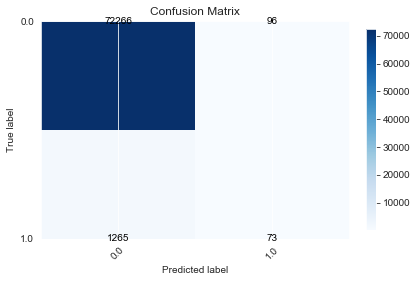

[[72266    96]
 [ 1265    73]]


In [283]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)

plt.imshow(cnf_matrix, cmap=plt.cm.Blues, aspect='auto') 
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
# Add appropriate axis scales
class_names = set(y) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
# Add labels to each cell
thresh = cnf_matrix.max() / 2 # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j], verticalalignment='center', horizontalalignment='center', color='black')
plt.colorbar(fraction=.03)
plt.show()

# Also show matrix values in 2x2 array since color display has some formatting issues
print(cnf_matrix)

## Evaluation Metrics - Precision, Recall, Accuracy and F1 Score
- True Positives (TP): correctly predicted severe crashes (73).
- True Negatives (TN): correctly predicted non-severe crashes (72,266).
- False Positives (FP): incorrectly predicted a severe crash when there was none (96).
- ***False Negatives (FN): incorrectly predicted a non-severe crash when it was actually severe (1265).***

`Precision:` TP / (TP+FP) - Out of how many times our model predicted a severe crash, how often was it correct?  
`Recall:` TP / (TP+FN) - Out of how many times severe crashes actually occurred, how often did our model correctly predict them?  
`Accuracy:` (TP+TN) / (TP+TN+FP+FN) - How often did our model correctly predict both severe and non-severe crashes altogether?  
`F1 Score:` 2x(PrecisionxRecall) / (Precision+Recall) - the 'harmonic mean of precision and recall' or a balanced metric incorporating both. While F1 score is generally the most balanced metric for describing the performance of a model, in our case maximizing it will be secondary to our goal of maximizing recall.

In [284]:
# Function for printing evaluation metrics
def metrics():
    print('Training Precision: ', precision_score(y_train, y_hat_train)*100)
    print('Testing Precision: ', precision_score(y_test, y_hat_test)*100)
    print('Training Recall: ', recall_score(y_train, y_hat_train)*100)
    print('Testing Recall: ', recall_score(y_test, y_hat_test)*100)
    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train)*100)
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test)*100)
    print('Training F1-Score: ', f1_score(y_train, y_hat_train)*100)
    print('Testing F1-Score: ', f1_score(y_test, y_hat_test)*100)
    cnf_matrix = confusion_matrix(y_test, y_hat_test)
    print(cnf_matrix)

metrics()

Training Precision:  36.93877551020408
Testing Precision:  43.19526627218935
Training Recall:  4.442808051055474
Testing Recall:  5.4559043348281016
Training Accuracy:  98.09948529611303
Testing Accuracy:  98.15332428765264
Training F1-Score:  7.931638913234004
Testing F1-Score:  9.688122096881221
[[72266    96]
 [ 1265    73]]


### As we can see here, this model's recall is simply *abysmal* at under 5%.. as well as precision and F1 score. 

## ROC Curves and AUC
The Receiver Operating Characteristic (ROC) curve graphs the False Positive Rate against the True Positive Rate. The overall accuracy of a classifier can be quantified by the Area Under the Curve (AUC). Perfect classifiers would have an AUC score of 1.0 while an AUC of 0.5 is deemed trivial or worthless.
> **Note:** We are examining these metrics mainly out of curiosity since we're focusing on False Negatives vs. False Positives. ROC curves are more useful when both classes detection are equally important (not for this project).

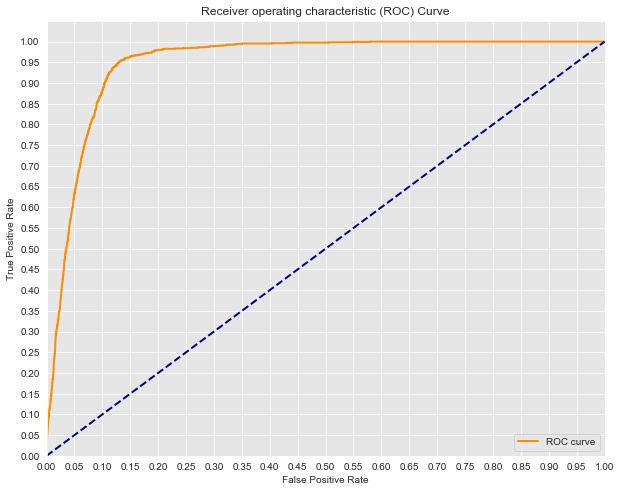

AUC: 0.9498189719525509


In [285]:
def roc_auc():    
    # First calculate the probability scores of each of the datapoints
    y_score = logreg.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    # Plot using seaborn
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show();
    print('AUC: {}'.format(auc(fpr, tpr)))

roc_auc()

### Our model did quite well according to these 2 metrics.. which makes sense when accuracy is the most heavily weighted. Now let's see what happens when we tweak our model to assign weights inversely proportional to frequencies by specifying the 'class weight' parameter. This is one way of addressing the *class imbalance* in our dataset.

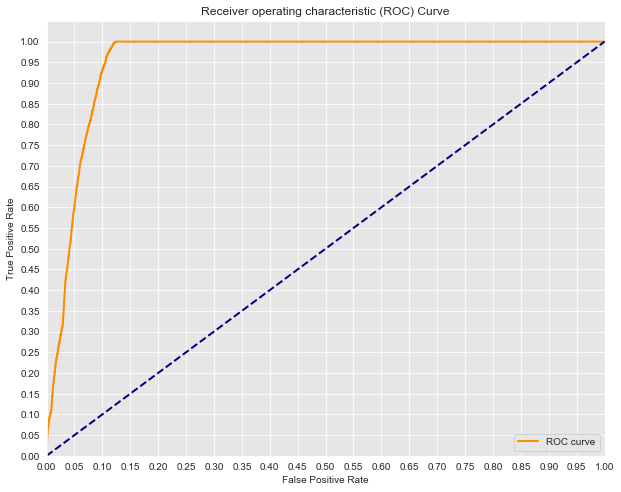

AUC: 0.9542005918672722
[[64192  8170]
 [   28  1310]] 

Training Precision:  14.137979883836238
Testing Precision:  13.818565400843882
Training Recall:  97.98723613156602
Testing Recall:  97.90732436472346
Training Accuracy:  88.99763905598422
Testing Accuracy:  88.87652645861601
Training F1-Score:  24.710615908387496
Testing F1-Score:  24.218894435200593
[[64192  8170]
 [   28  1310]]


(None, None)

In [286]:
logreg = LogisticRegression(fit_intercept = False, solver='liblinear', class_weight='balanced') #only this parameter changed
model_log = logreg.fit(X_train, y_train)
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

# Show ROC/AUC, confusion matrix and metric scores
roc_auc()
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print(cnf_matrix,'\n'), metrics()

### Wow, that was unexpected! We sacrificed less than 10% of overall accuracy but our recall increased by over 2000%!
> Out of **1,338** severe crashes, our model correctly predicted **1,310** of them. Overall F1 score almost tripled while we lost over half of our precision. This is apparent in our model's 8,170 incorrect severe crash predictions that were actually non-severe.

> If the City of Chicago directs funds and resources to reduce high risk factors identified in this model, over 85% of these efforts could be considered 'wasted' due to our drop in precision (vs. ~60% before). However, in the realm of safety and human injury/death prevention - many would argue that there is no cost too great. What our model gained: **correctly predicting every severe crash almost 98% of the time (vs less than 5% before) - was clearly worth it.**

## Feature Selection
- Chi-Squared Test scores dependence between categorical variables 

In [287]:
# Get original dataset with all feature columns
df_fs = pd.get_dummies(df[features], drop_first=True, dtype=float)
# Normalize by performing min-max scaling from 0 to 1
for col in df_fs.columns:
    df_fs[col] = (df_fs[col] - min(df_fs[col]))/ (max(df_fs[col]) - min(df_fs[col]))
X = sm.tools.add_constant(df_fs)  #add constant

# Using Chi-Squared test with KNN classifier
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X, y)

chi_fs = {}  #dictionary to hold feature names and scores
for i in range(1, len(fs.scores_)):
    chi_fs[df_fs.columns[i-1]] = fs.scores_[i]

# Print list of features sorted by score, ranking from best to worst
sorted(chi_fs.items(), key=lambda x: x[1], reverse=True)

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


[('INJURIES_TOTAL', 15223.69142872241),
 ('FIRST_CRASH_TYPE_PED/CYCLE/OTHER', 8970.591269492234),
 ('AIRBAG', 4390.007007770557),
 ('EJECTION', 3201.6733617659197),
 ('POL_NOTIFY_TIME_QUICK', 2756.986720081328),
 ('REPORT_TYPE', 2047.5611145318128),
 ('POL_NOTIFY_TIME_MID', 728.6256976865347),
 ('FIRST_CRASH_TYPE_SIDESWIPE', 451.2037486779595),
 ('ALCOHOL', 416.46452807907696),
 ('NON_DRIVERS', 332.6780276085575),
 ('FIRST_CRASH_TYPE_PARKED/FIXED', 282.77978908612783),
 ('FIRST_CRASH_TYPE_REAR/NONCOL', 245.86995563169643),
 ('DAMAGE_OVER $1,500', 184.6433131074776),
 ('HIT_AND_RUN_I', 181.83506431197716),
 ('LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD', 181.40379605227008),
 ('POL_NOTIFY_TIME_LOW', 137.1614170320656),
 ('POSTED_SPEED_LIMIT_low', 126.69003587085787),
 ('CRASH_HOUR_NIGHT', 124.73934472178044),
 ('WEIGHT_DIFF', 115.5165015309676),
 ('SPEEDING', 100.72758187106498),
 ('ROADWAY_SURFACE_COND_UNKNOWN/OTHER', 100.02320057679184),
 ('NO_TCD', 99.6956325877709),
 ('WEATHER_CONDITI

#### Looks like the majority of the top 28 features from this test are similar to the 28 we 'manually' selected above. Let's see if the model improves.

In [288]:
drop_list = []  #create list of top 28 column names to remove if score < 45
for x in chi_fs.items():
    if x[1]<45: drop_list.append(x[0])
for x in drop_list:
    chi_fs.pop(x)

# Model only newly selected feature columns
dummies_fs = pd.get_dummies(df_fs[chi_fs.keys()], drop_first=True, dtype=float)  #dummy encoding
for col in dummies_fs.columns:  #min-max scaling
    dummies_fs[col] = (dummies_fs[col] - min(dummies_fs[col]))/ (max(dummies_fs[col]) - min(dummies_fs[col]))
X = sm.tools.add_constant(dummies_fs)
X_train, X_test, y_train, y_test = train_test_split(dummies_fs, y, random_state=1)

# fit_intercept=False because we already added a constant
logreg = LogisticRegression(fit_intercept = False, solver='liblinear', class_weight='balanced')
model_log = logreg.fit(X_train, y_train)
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

# Show confusion matrix and metric scores
metrics()

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Training Precision:  13.854643243809589
Testing Precision:  13.546438983756767
Training Recall:  97.37358861070201
Testing Recall:  97.23467862481316
Training Accuracy:  88.7954662638287
Testing Accuracy:  88.68385345997287
Training F1-Score:  24.257804139786586
Testing F1-Score:  23.779930542862367
[[64059  8303]
 [   37  1301]]


#### Virtually the same if not slightly worse..

In [289]:
# Viewing feature list differences
df_fs[chi_fs.keys()].columns, dummies.columns

(Index(['LANE_CNT', 'REPORT_TYPE', 'HIT_AND_RUN_I', 'INJURIES_TOTAL', 'NO_TCD',
        'NON_DRIVERS', 'WEIGHT_DIFF', 'SPEEDING', 'ALCOHOL', 'AIRBAG',
        'EJECTION', 'POSTED_SPEED_LIMIT_low', 'WEATHER_CONDITION_UNKNOWN/OTHER',
        'LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD',
        'LIGHTING_CONDITION_DAYLIGHT', 'FIRST_CRASH_TYPE_PARKED/FIXED',
        'FIRST_CRASH_TYPE_PED/CYCLE/OTHER', 'FIRST_CRASH_TYPE_REAR/NONCOL',
        'FIRST_CRASH_TYPE_SIDESWIPE', 'ROADWAY_SURFACE_COND_UNKNOWN/OTHER',
        'ROADWAY_SURFACE_COND_WET', 'ROAD_DEFECT_UNKNOWN/OTHER/DEBRIS',
        'DAMAGE_OVER $1,500', 'CRASH_HOUR_DAY', 'CRASH_HOUR_NIGHT',
        'POL_NOTIFY_TIME_LOW', 'POL_NOTIFY_TIME_MID', 'POL_NOTIFY_TIME_QUICK'],
       dtype='object'),
 Index(['LANE_CNT', 'REPORT_TYPE', 'HIT_AND_RUN_I', 'INJURIES_TOTAL',
        'NON_DRIVERS', 'SPEEDING', 'UNDER25', 'ALCOHOL', 'AIRBAG', 'EJECTION',
        'WEATHER_CONDITION_CLOUDY/RAIN', 'WEATHER_CONDITION_FOG/SMOKE/HAZE',
        'LIGHTING_CON

## Modeling with Decision Trees

In [290]:
# First perform train-test split from original pickle imported dataset
X_train, X_test, y_train, y_test = train_test_split(df[features], y, random_state=1)  #specify random seed for reproducibility

# One-hot encode and fit to training data
ohe = OneHotEncoder()
ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train)

# Create the classifier, fit on the training data
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train_ohe, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [291]:
# Run predictions and print metrics, confusion matrix
y_hat_test = tree.predict(ohe.transform(X_test))
y_hat_train = tree.predict(ohe.transform(X_train))
metrics()

#pd.crosstab(y_test, y_hat_test, rownames=['True'], colnames=['Predicted'], margins=True)

Training Precision:  99.75636166756902
Testing Precision:  18.218623481781375
Training Recall:  90.45164457535591
Testing Recall:  20.179372197309416
Training Accuracy:  99.81998932600024
Testing Accuracy:  96.90637720488466
Training F1-Score:  94.87641606591143
Testing F1-Score:  19.148936170212767
[[71150  1212]
 [ 1068   270]]


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0991437 to fit



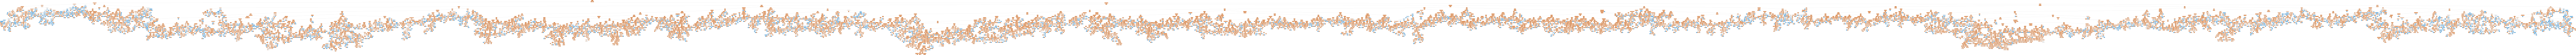

In [293]:
# Visualize decision tree
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

# Create DOT data
X_train_ohe = ohe.transform(X_train).toarray()
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)
import os  #workaround to get graphviz to work
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
Image(graph.create_png())

#### Darn, looks like there are just too many features (dimensions) to be able to visualize the decision tree. Let's see if changing the criterion parameter makes a difference.

In [294]:
# Create the classifier with default criterion, fit on the training data
tree = DecisionTreeClassifier(criterion='gini')
tree.fit(X_train_ohe, y_train)
y_hat_test = tree.predict(ohe.transform(X_test))
y_hat_train = tree.predict(ohe.transform(X_train))
metrics()

Training Precision:  99.75636166756902
Testing Precision:  16.904024767801857
Training Recall:  90.45164457535591
Testing Recall:  20.40358744394619
Training Accuracy:  99.81998932600024
Testing Accuracy:  96.73405698778834
Training F1-Score:  94.87641606591143
Testing F1-Score:  18.48967152048764
[[71020  1342]
 [ 1065   273]]


### No real differences but the resulting metrics indicate possible overtraining as presented by the large disparity between the training and test sets. Let's see if we can perform some hyperparameter tuning.

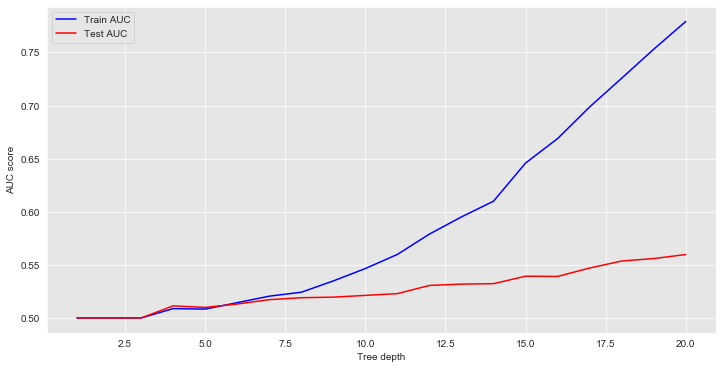

In [295]:
# Identify the optimal tree depth
max_depths = np.linspace(1, 20, 20)
train_results, test_results = [], []
for max_depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=1)
    tree.fit(X_train_ohe, y_train)
    train_pred = tree.predict(ohe.transform(X_train))
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = tree.predict(ohe.transform(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

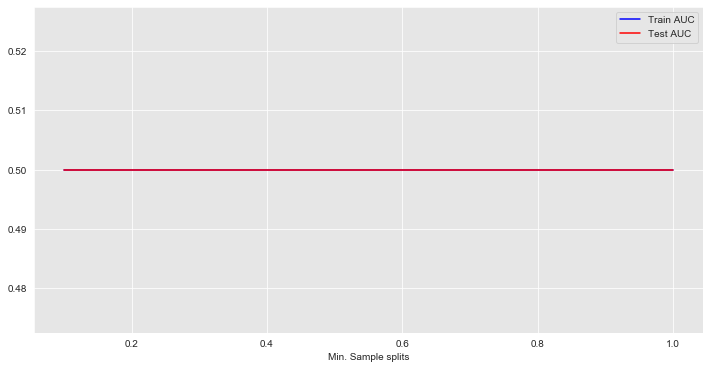

In [296]:
# Identify the optimal min-samples-split
min_samples_splits = np.linspace(0.1, 1.0, 10)
train_results, test_results = [], []
for min_samples in min_samples_splits:
    tree = DecisionTreeClassifier(min_samples_split=min_samples, random_state=1)
    tree.fit(X_train_ohe, y_train)
    train_pred = tree.predict(ohe.transform(X_train))
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    y_pred = tree.predict(ohe.transform(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

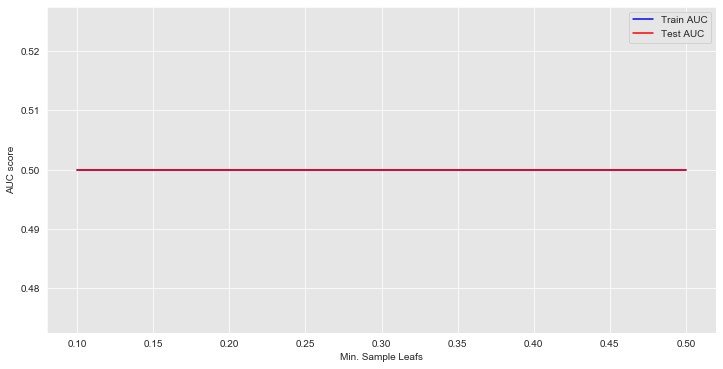

In [297]:
# Identify the optimal value for minimum sample leafs
min_samples_leafs = np.linspace(0.1, 0.5, 5)
train_results, test_results = [], []
for min_samples in min_samples_leafs:
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples, random_state=1)
    tree.fit(X_train_ohe, y_train)
    train_pred = tree.predict(ohe.transform(X_train))
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    y_pred = tree.predict(ohe.transform(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

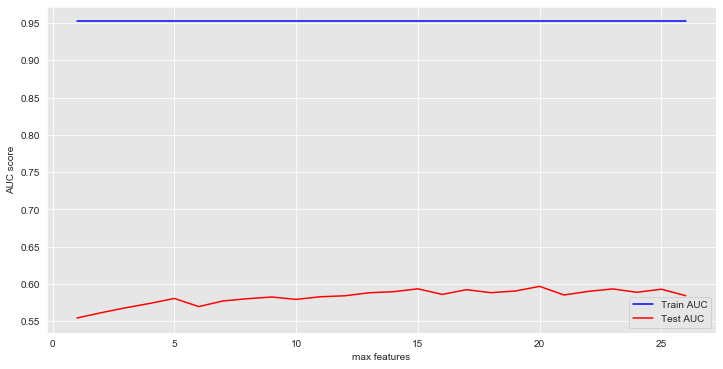

In [298]:
# Identify the optimal value for maximum number of features
max_features = list(range(1, X_train.shape[1]))
train_results, test_results = [], []
for max_feat in max_features:
    tree = DecisionTreeClassifier(max_features=max_feat, random_state=1)
    tree.fit(X_train_ohe, y_train)
    train_pred = tree.predict(ohe.transform(X_train))
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    y_pred = tree.predict(ohe.transform(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

### So it seems varying min_samples_split and leaf made no difference - they all scored the lowest possible AUC (0.5). Tree depth appears to be optimal from 3 to 7. Varying our numbers of features did not reveal anything other than that we should be possibly testing different train-test split sizes to reduce what looks like overfitting of our training data.

In [301]:
# Loop thru tree depths 3-7 and test split sizes from 0.1-0.5
# Output will be recall scores only
depths = [3,4,5,6,7]
sizes = np.linspace(0.1, 0.5, 5)
for size in sizes:
    X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=size, random_state=1)
    print(f'Test split size: {size}')
    for depth in depths:
        print(f'Tree Depth: {depth}')
        ohe.fit(X_train)
        X_train_ohe = ohe.transform(X_train)
        tree = DecisionTreeClassifier(max_depth=depth)
        tree.fit(X_train_ohe, y_train)
        y_hat_test = tree.predict(ohe.transform(X_test))
        y_hat_train = tree.predict(ohe.transform(X_train))
        print(recall_score(y_train, y_hat_train))
        print(recall_score(y_test, y_hat_test))
    print('\n')

Test split size: 0.1
Tree Depth: 3
0.0
0.0
Tree Depth: 4
0.01413355182302335
0.024528301886792454
Tree Depth: 5
0.016796394920114706
0.026415094339622643
Tree Depth: 6
0.021302744776730848
0.02830188679245283
Tree Depth: 7
0.02232691519868906
0.026415094339622643


Test split size: 0.2
Tree Depth: 3
0.0
0.0
Tree Depth: 4
0.018177634606534744
0.02345215759849906
Tree Depth: 5
0.017257248044178556
0.019699812382739212
Tree Depth: 6
0.03382420616658997
0.0375234521575985
Tree Depth: 7
0.03405430280717901
0.03095684803001876


Test split size: 0.30000000000000004
Tree Depth: 3
0.0
0.0
Tree Depth: 4
0.018210609659540775
0.021565003080714726
Tree Depth: 5
0.017154922143045658
0.019100431300061615
Tree Depth: 6
0.03615729743995777
0.033271719038817
Tree Depth: 7
0.022433359725521247
0.016019716574245224


Test split size: 0.4
Tree Depth: 3
0.0
0.0
Tree Depth: 4
0.014452644526445265
0.016203703703703703
Tree Depth: 5
0.01783517835178352
0.01898148148148148
Tree Depth: 6
0.035362853628536285
0.

### So we were not able to improve our decision tree models' recall via hyperparameter tuning - it seems leaving them at default works best.
## Random Forests

In [303]:
# Train-test split again at default 25%, one hot encode and fit to training data
X_train, X_test, y_train, y_test = train_test_split(df[features], y, random_state=1)
ohe = OneHotEncoder()
ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train)

# Initialize and fit a RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train_ohe, y_train)

# Test set predictions
y_hat_test = forest.predict(ohe.transform(X_test))
y_hat_train = forest.predict(ohe.transform(X_train))
metrics()

Training Precision:  98.62433862433862
Testing Precision:  28.90995260663507
Training Recall:  91.50711831124202
Testing Recall:  4.559043348281016
Training Accuracy:  99.81998932600024
Testing Accuracy:  98.06377204884667
Training F1-Score:  94.93251846193023
Testing F1-Score:  7.876049063912202
[[72212   150]
 [ 1277    61]]


In [304]:
# Try with max depth of 5
tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree.fit(X_train_ohe, y_train)
y_hat_test = tree.predict(ohe.transform(X_test))
y_hat_train = tree.predict(ohe.transform(X_train))
metrics()

Training Precision:  60.0
Testing Precision:  55.10204081632652
Training Recall:  1.6936671575846833
Testing Recall:  2.0179372197309418
Training Accuracy:  98.16778080308279
Testing Accuracy:  98.19131614654003
Training F1-Score:  3.2943423251372637
Testing F1-Score:  3.8932948810382126
[[72340    22]
 [ 1311    27]]


### At least with this specific dataset, it seems the binary (and possibly 'greedy') nature of decision trees make it difficult to maximize recall by minimizing false negatives. They do seem to perform better at minimizing false positives, which our logistic regression model gave up in spades in order to eliminate the false negatives.
- It's possible that we can transform our dataset with other techniques such as resampling. Oversampling our under-represented class of severe crashes, removing instances of the over-represented non-severe class, or even generating synthetic data. Those could be additional aspects to explore in another project.

### Now let's try some boosting algorithms and Support Vector Machines (SVM).

In [305]:
# Initiate and fit Ada Boost, Gradient Boosting classifiers
ada_clf = AdaBoostClassifier(random_state=1)
gbt_clf = GradientBoostingClassifier(random_state=1)

ada_clf.fit(X_train_ohe, y_train)
gbt_clf.fit(X_train_ohe, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [306]:
# AdaBoost model predictions
y_hat_train = ada_clf.predict(ohe.transform(X_train))
y_hat_test = ada_clf.predict(ohe.transform(X_test))
metrics()

Training Precision:  60.0
Testing Precision:  70.83333333333334
Training Recall:  0.6627393225331369
Testing Recall:  1.2705530642750373
Training Accuracy:  98.16144876932401
Testing Accuracy:  98.19810040705563
Training F1-Score:  1.3109978150036417
Testing F1-Score:  2.4963289280469896
[[72355     7]
 [ 1321    17]]


In [307]:
# GradientBoosting model predictions
y_hat_train = gbt_clf.predict(ohe.transform(X_train))
y_hat_test = gbt_clf.predict(ohe.transform(X_test))
metrics()

Training Precision:  64.4927536231884
Testing Precision:  69.81132075471697
Training Recall:  2.1845851742758957
Testing Recall:  2.7653213751868457
Training Accuracy:  98.17546970121846
Testing Accuracy:  98.21302578018995
Training F1-Score:  4.226020892687559
Testing F1-Score:  5.319913731128684
[[72346    16]
 [ 1301    37]]


#### We ran the SVM model overnight hoping for a result but it crapped out at under 4 hours (does the error message mean a keyboard command stopped the process while I was sleeping??).. so it will remain a mystery.

In [251]:
# Fit SVM model
svm_ = svm.SVC(probability=True)
svm_.fit(X_train_ohe, y_train)

y_hat_test = tree.predict(ohe.transform(X_test))
y_hat_train = tree.predict(ohe.transform(X_train))
metrics()

KeyboardInterrupt: 

### In closing, what we have learned over the course of this project turned out to be quite interesting. Attempting to maximize recall over accuracy created new corners to explore and going down roads we did not expect. As it turns out - our sophisticated, complex and time consuming algorithms turned out to be the worst performers. Of course, this could be (and likely is) due to our lack of experience in tuning hyperparameters for these algorithms - which is of crucial importance.
> As we saw earlier, a simple parameter tweak achieved a night and day difference to our model's effectiveness. The fairly simple (and 'manually feature tuned') logistic regression model based on MLE and probabilities maximized the specific type of prediction accuracy (recall - not 'actual accuracy') that we were looking for and would be most useful in the real world.


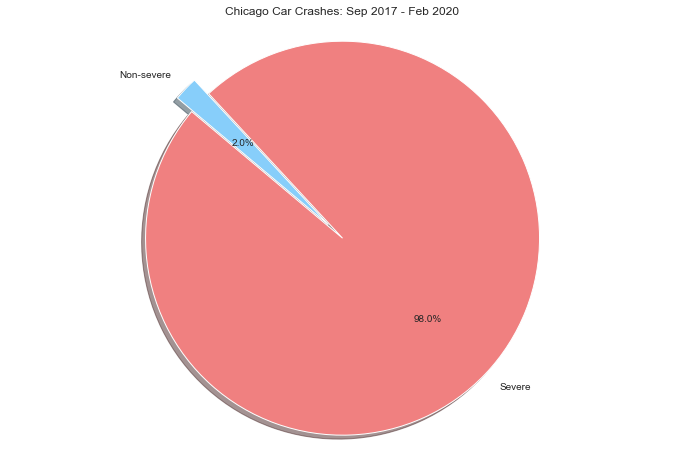

In [314]:
# creating pie chart for use in presentation
labels = 'Severe', 'Non-severe'
sizes = [98, 2]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(12,8))
plt.title('Chicago Car Crashes: Sep 2017 - Feb 2020')
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

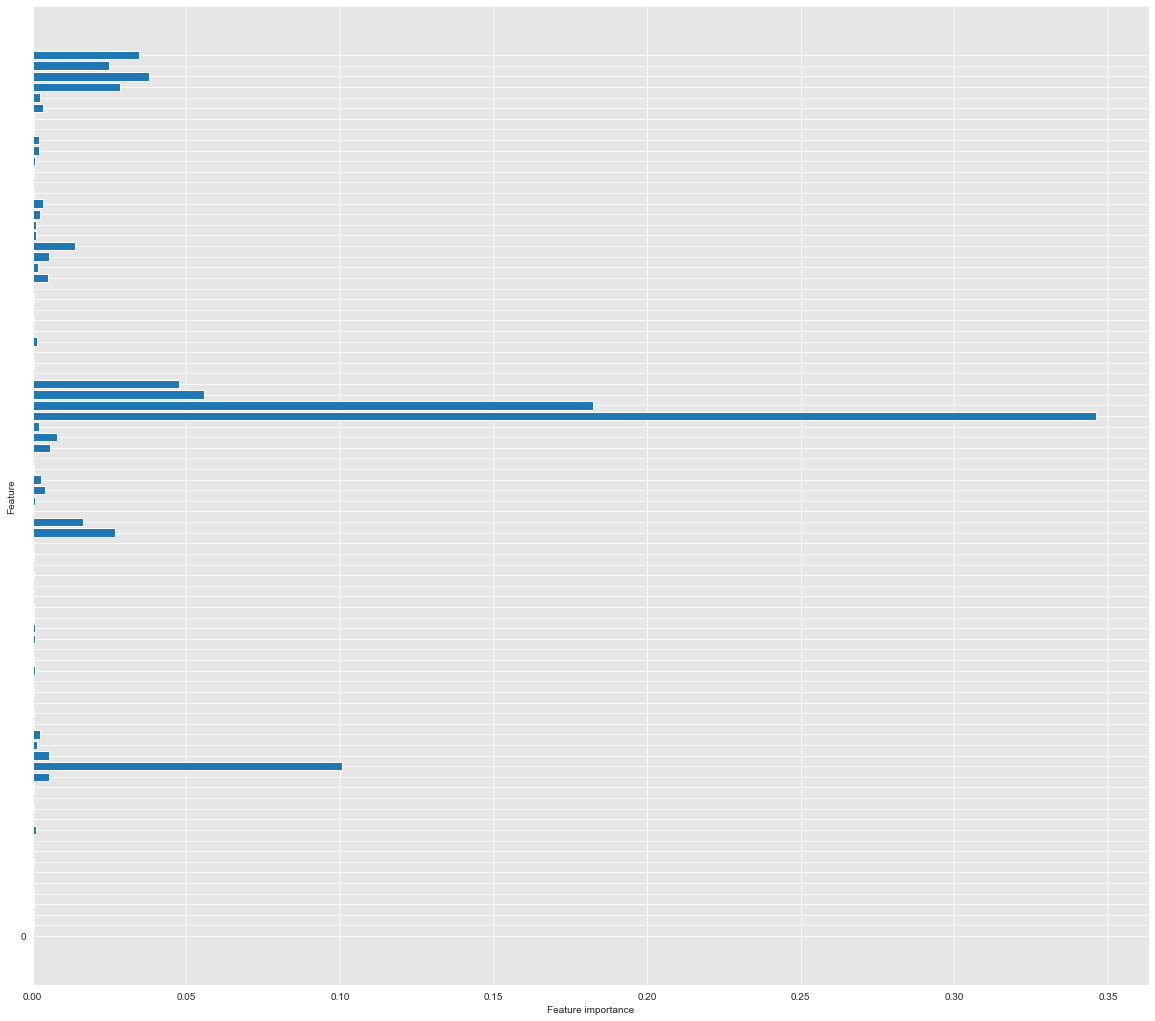

In [231]:
# Plot decision tree feature columns and their weights
def plot_feature_importances():
    n_features = X_train_ohe.shape[1]
    plt.figure(figsize=(20,18))
    plt.barh(range(n_features), forest.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), pd.DataFrame(X_train_ohe).columns)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances()